In [10]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
from collections import Counter, defaultdict
import itertools
import math

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import brier_score_loss
from sklearn.dummy import DummyClassifier


# Generating the dataset
We take the led dataset and add noise to it to introduce randomness and compare between train and test sets.

In [4]:
def make_noised_led_sample(
    n_samples=200, irrelevant=0, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_samples)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_samples):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant > 0:
        X_noised = np.hstack((X_noised, random_state.rand(n_samples, irrelevant) > 0.5))
    return X_noised, y


# Compare asymptotics of MDI and UMDI

In [ ]:
n_rep = 5
flip_proba = 0.2
max_n_sample = 1e4
n_estimators = 100
train_sizes_large = np.logspace(start=2, stop=np.log10(max_n_sample), base=10, num=10, dtype=np.intp)


In [82]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
mdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
umdi_all = np.zeros((len(feature_names), len(train_sizes_large), n_rep))
oob_scores= []
for t_idx, n_samples in enumerate(train_sizes_large):
    oob_scores_fold = []
    for rep in range(n_rep):
        X, y = make_noised_led_sample(
            n_samples=n_samples, flip_proba=flip_proba, random_state=rep
        )
        X = X.astype(np.float32)
        rf = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            n_jobs=-1,
            random_state=rep,
        )
        rf.fit(X, y)        
        mdi_all[:, t_idx, rep] = rf._unnormalized_feature_importances
        
        rf = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rep,
        )
        rf.fit(X, y)
        umdi = rf.unbiased_feature_importances_
        umdi_all[:, t_idx, rep] = umdi
        oob_scores_fold.append(rf.oob_score_)
    oob_scores.append(np.mean(oob_scores_fold))

In [5]:
# Compute shapley values
sage_values = []
n_samples = 10000
for rep in range(n_rep):
    X_train, y_train = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=rep
    )

    rf = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=1,
        max_depth=None,
        n_jobs=-1,
        random_state=rep,
    )
    rf.fit(X_train, y_train)
    
    X_test, y_test = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, random_state=rep + 100
    )
    y_test_one_hot = np.eye(10)[y_test]
    imputer = sage.MarginalImputer(rf, X_test[:500])
    estimator = sage.PermutationEstimator(
        imputer, "mse", random_state=rep
    )
    sage_value = estimator(X_test, y_test_one_hot, thresh=0.05).values
    sage_values.append(sage_value)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Compute FI as a decomposition of mutual information

In [ ]:
def conditional_mutual_information(X, y, m, S):
    n_samples = X.shape[0]
    counter = Counter()

    # Build joint frequency tables
    for i in range(n_samples):
        x_m = X[i, m]
        s_vals = tuple(X[i, S]) if len(S) > 0 else ()
        y_val = y[i]
        counter[('xmys', x_m, y_val, s_vals)] += 1
        counter[('xms', x_m, s_vals)] += 1
        counter[('ys', y_val, s_vals)] += 1
        counter[('s', s_vals)] += 1

    cmi = 0.0
    for key_tuple, p_joint_count in counter.items():
        key = key_tuple[0]
        if key != 'xmys':
            continue
        _, x_m, y_val, s_vals = key_tuple
        p_xyz = p_joint_count / n_samples
        p_xz = counter[('xms', x_m, s_vals)] / n_samples
        p_yz = counter[('ys', y_val, s_vals)] / n_samples
        p_z = counter[('s', s_vals)] / n_samples


        # Avoid division by zero
        if p_xyz > 0 and p_xz > 0 and p_yz > 0 and p_z > 0:
            cmi += p_xyz * np.log(p_xyz * p_z / (p_xz * p_yz))

    return cmi

def compute_importance_theoric(X, y, m):
    p = X.shape[1]
    V_minus_m = [i for i in range(p) if i != m]
    total_importance = 0.0

    for k in range(p):
        subsets = list(itertools.combinations(V_minus_m, k))
        cmi_sum = 0.0

        for B in subsets:
            cmi = conditional_mutual_information(X, y, m, list(B))
            cmi_sum += cmi

        num_subsets = len(subsets)
        if num_subsets > 0:
            weight = 1.0 / (math.comb(p, k) * (p - k))
            total_importance += weight * cmi_sum  

    return total_importance


In [8]:
# n_rep = 5
# theoretical_value = []
# for rep in range(n_rep):
#     X, y = make_noised_led_sample(n_samples=int(max_n_sample), flip_proba=flip_proba, random_state=rep)
#     imp = np.array([compute_importance_theoric(X, y, m) for m in range(7)])
#     theoretical_value.append(imp)

# np.mean(theoretical_value, axis=0)

In [ ]:
def conditional_variance(X, y, m, S):
    """
    Compute conditional variance difference : Var(Y|X_S) - Var(Y|X_m, X_S)
    
    For categorical Y, this uses the variance of class probabilities.
    """
    n_samples = X.shape[0]
    
    # Convert y to class indices if needed
    if y.ndim > 1:
        y = np.argmax(y, axis=1)
    
    classes = np.unique(y)
    n_classes = len(classes)
    
    # Build conditioning contexts
    contexts_s = defaultdict(list)
    contexts_sm = defaultdict(list)
    
    for i in range(n_samples):
        s_vals = tuple(X[i, S]) if len(S) > 0 else ()
        sm_vals = tuple(X[i, S + [m]]) if len(S) > 0 else (X[i, m],)
        
        contexts_s[s_vals].append(y[i])
        contexts_sm[sm_vals].append(y[i])
    
    # Compute Var(Y|S) - weighted average of Gini impurities
    var_given_s = 0.0
    for s_vals, y_subset in contexts_s.items():
        weight = len(y_subset) / n_samples
        
        # Compute Gini impurity for this context
        class_counts = np.bincount(y_subset, minlength=n_classes)
        class_probs = class_counts / len(y_subset)
        gini_impurity = 1.0 - np.sum(class_probs ** 2)
        
        var_given_s += weight * gini_impurity
    
    # Compute Var(Y|S, X_m)
    var_given_sm = 0.0
    for sm_vals, y_subset in contexts_sm.items():
        weight = len(y_subset) / n_samples
        
        # Compute Gini impurity for this context
        class_counts = np.bincount(y_subset, minlength=n_classes)
        class_probs = class_counts / len(y_subset)
        gini_impurity = 1.0 - np.sum(class_probs ** 2)
        
        var_given_sm += weight * gini_impurity
    
    return var_given_s - var_given_sm

def shapley_conditional_variance(X, y, m):
    """
    Compute Shapley value using conditional variance.
    """
    p = X.shape[1]
    V_minus_m = [i for i in range(p) if i != m]
    total_importance = 0.0
    
    # Iterate over all possible subsets of features excluding m
    for k in range(p):
        subsets = list(itertools.combinations(V_minus_m, k))
        
        for S in subsets:
            # Marginal contribution of feature m given subset S
            marginal_contrib = conditional_variance(X, y, m, list(S))
            
            # Shapley weight for this subset
            weight = math.factorial(k) * math.factorial(p - k - 1) / math.factorial(p)
            
            total_importance += weight * marginal_contrib
    
    return total_importance


In [10]:
n_rep = 5
theoretical_value = []
for rep in range(n_rep):
    X, y = make_noised_led_sample(n_samples=int(max_n_sample), flip_proba=flip_proba, random_state=rep)
    imp = np.array([shapley_conditional_variance(X, y, m) for m in range(7)])
    theoretical_value.append(imp)

np.mean(theoretical_value, axis=0)

array([0.03634424, 0.04736673, 0.03557979, 0.04415551, 0.04877032,
       0.02097986, 0.03628591])

# Plot the difference between (U)MDI and the theoretical value

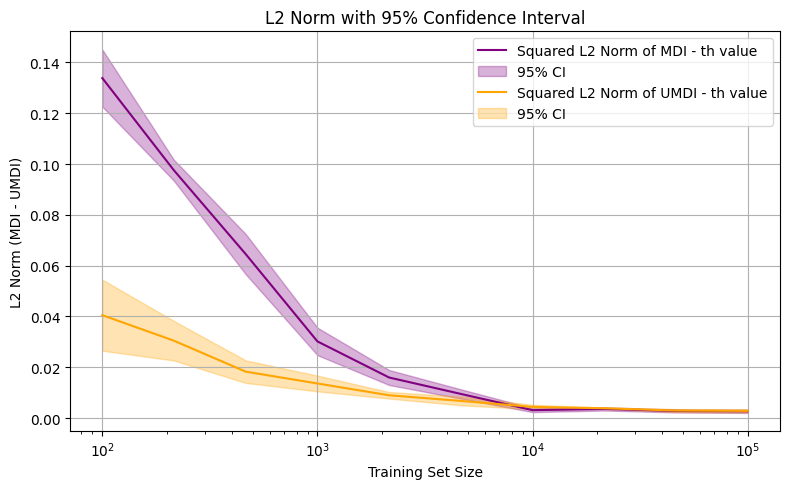

In [83]:
l2_mean_mdi = []
l2_sem_mdi = []
l2_mean_umdi = []
l2_sem_umdi = []

for t_idx in range(len(train_sizes_large)):
    mdi_vals = mdi_all[:, t_idx, :]
    umdi_vals = umdi_all[:, t_idx, :]

    l2_squared_mdi = np.sqrt(np.sum((mdi_vals - np.mean(theoretical_value, axis=0).repeat(5).reshape(7,5)) ** 2, axis=0))
    l2_squared_umdi = np.sqrt(np.sum((umdi_vals - np.mean(theoretical_value, axis=0).repeat(5).reshape(7,5)) ** 2, axis=0))
    l2_mean_mdi.append(l2_squared_mdi.mean())
    l2_sem_mdi.append(l2_squared_mdi.std(ddof=1) / np.sqrt(n_rep))
    l2_mean_umdi.append(l2_squared_umdi.mean())
    l2_sem_umdi.append(l2_squared_umdi.std(ddof=1) / np.sqrt(n_rep))

l2_mean_mdi = np.array(l2_mean_mdi)
l2_mean_umdi = np.array(l2_mean_umdi)
l2_sem_mdi = np.array(l2_sem_mdi)
l2_sem_umdi = np.array(l2_sem_umdi)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes_large, l2_mean_mdi, label='Squared L2 Norm of MDI - th value', color='purple')
plt.fill_between(
    train_sizes_large,
    l2_mean_mdi - 1.96 * l2_sem_mdi,
    l2_mean_mdi + 1.96 * l2_sem_mdi,
    color='purple',
    alpha=0.3,
    label='95% CI'
)

plt.plot(train_sizes_large, l2_mean_umdi, label='Squared L2 Norm of UMDI - th value', color='orange')
plt.fill_between(
    train_sizes_large,
    l2_mean_umdi - 1.96 * l2_sem_umdi,
    l2_mean_umdi + 1.96 * l2_sem_umdi,
    color='orange',
    alpha=0.3,
    label='95% CI'
)
plt.xscale('log')
plt.xlabel('Training Set Size')
plt.ylabel('L2 Norm (MDI - UMDI)')
plt.title('L2 Norm with 95% Confidence Interval')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Plot evolution as a heatmap and compare with SAGE

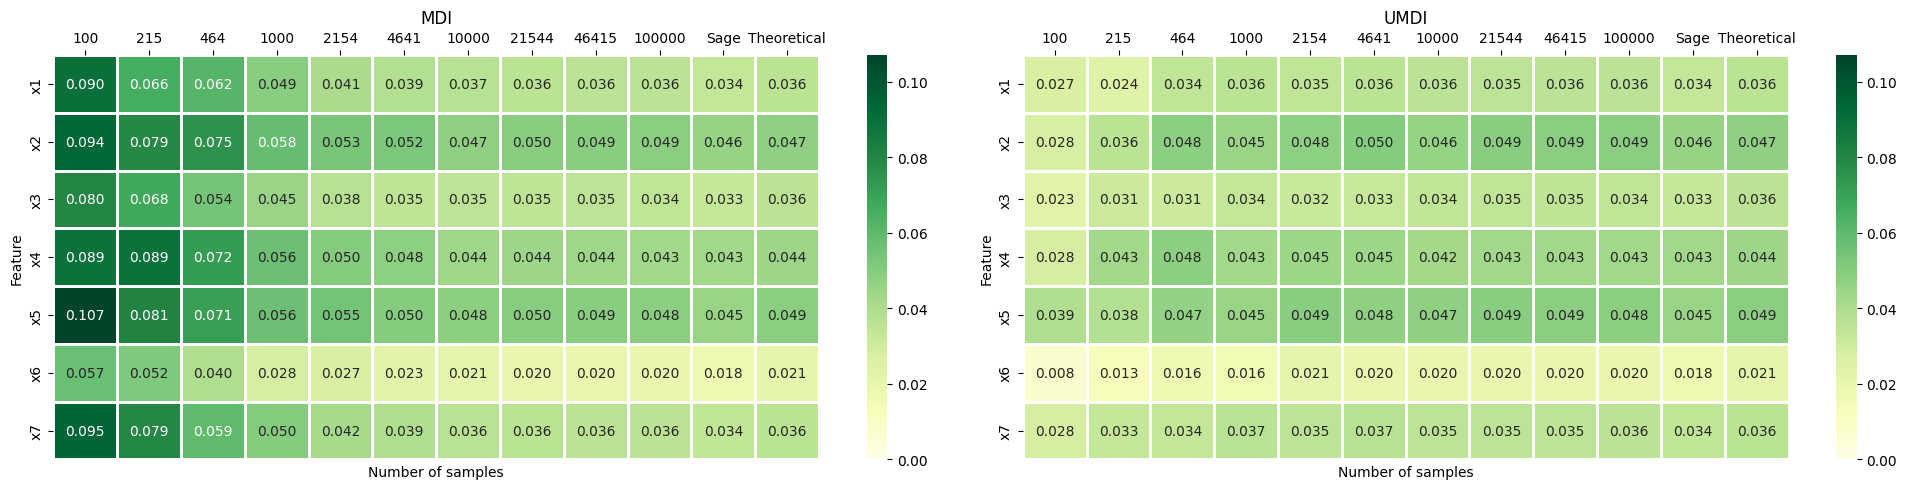

In [84]:
MDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_asymptotic = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for t_idx in range(len(train_sizes_large)):
    MDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(mdi_all[:, t_idx, :], axis=1)
    UMDI_asymptotic.loc[:,f"{train_sizes_large[t_idx]}"] = np.mean(umdi_all[:, t_idx, :], axis=1)

UMDI_asymptotic.loc[:, "Sage"] = np.mean(sage_values, axis=0)
MDI_asymptotic.loc[:, "Sage"] = np.mean(sage_values, axis=0)
UMDI_asymptotic.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)
MDI_asymptotic.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)

max_value = np.max([UMDI_asymptotic.max(), MDI_asymptotic.max()])

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(
    MDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[0],
    vmin=0,
    vmax=max_value,
)
axes[0].xaxis.tick_top()
axes[0].set_xlabel("Number of samples")
axes[0].set_ylabel("Feature")
axes[0].set_title("MDI")

sns.heatmap(
    UMDI_asymptotic,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[1],
    vmin=0,
    vmax=max_value,
)
axes[1].xaxis.tick_top()
axes[1].set_xlabel("Number of samples")
axes[1].set_ylabel("Feature")
axes[1].set_title("UMDI")

plt.tight_layout()
plt.show()

# Compare the sum of theoretical shapley values and compare to the brier score of the null and expressive models

In [ ]:
X, y = make_noised_led_sample(20000, flip_proba=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

rf = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=None,
    max_features=1,
    min_samples_leaf=1,
    random_state=42,
)
rf.fit(X_train, y_train)

dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)

theoretical_value_nofolds = np.array(
    [shapley_conditional_variance(X, y, m) for m in range(7)]
)
print("Sum of theoretical value: ", theoretical_value_nofolds.sum())
print(
    "Brier score of the full model: ",
    brier_score_loss(y_test, rf.predict_proba(X_test)),
)
print(
    "Brier score of the null model: ",
    brier_score_loss(y_test, dummy.predict_proba(X_test)),
)
print(
    "Difference in Brier score: ",
    brier_score_loss(y_test, dummy.predict_proba(X_test))
    - brier_score_loss(y_test, rf.predict_proba(X_test)),
)
print(
    "Brier score improvement potential: ",
    theoretical_value_nofolds.sum()
    - (
        brier_score_loss(y_test, dummy.predict_proba(X_test))
        - brier_score_loss(y_test, rf.predict_proba(X_test))
    ),
)

Sum of theoretical value:  0.26958053195121967
Brier score of the full model:  0.6438119311797232
Brier score of the null model:  0.9000635400000001
Difference in Brier score:  0.25625160882027687
Brier score improvement potential:  0.013328923130942805


# Repeat the experiment for varying values of `max_feature`.

In [100]:
max_n_sample = 1e4
train_sizes = np.logspace(start=2, stop=np.log10(max_n_sample), base=10, num=5, dtype=np.intp)
mf_values = [1, 4, 7]
umdi_mf = np.zeros((len(feature_names), len(train_sizes), n_rep, len(mf_values)))

for mf_idx, mf in enumerate(mf_values):
    for t_idx, n_samples in enumerate(train_sizes):
        for rep in range(n_rep):
            X, y = make_noised_led_sample(
                n_samples=n_samples, flip_proba=flip_proba, random_state=rep
            )
            rf = ExtraTreesClassifier(
                n_estimators=n_estimators,
                max_features=mf,
                max_depth=None,
                oob_score=True,
                bootstrap=True,
                n_jobs=-1,
                random_state=rep,
            )
            rf.fit(X, y)
            umdi_mf[:, t_idx, rep, mf_idx] = rf.unbiased_feature_importances_

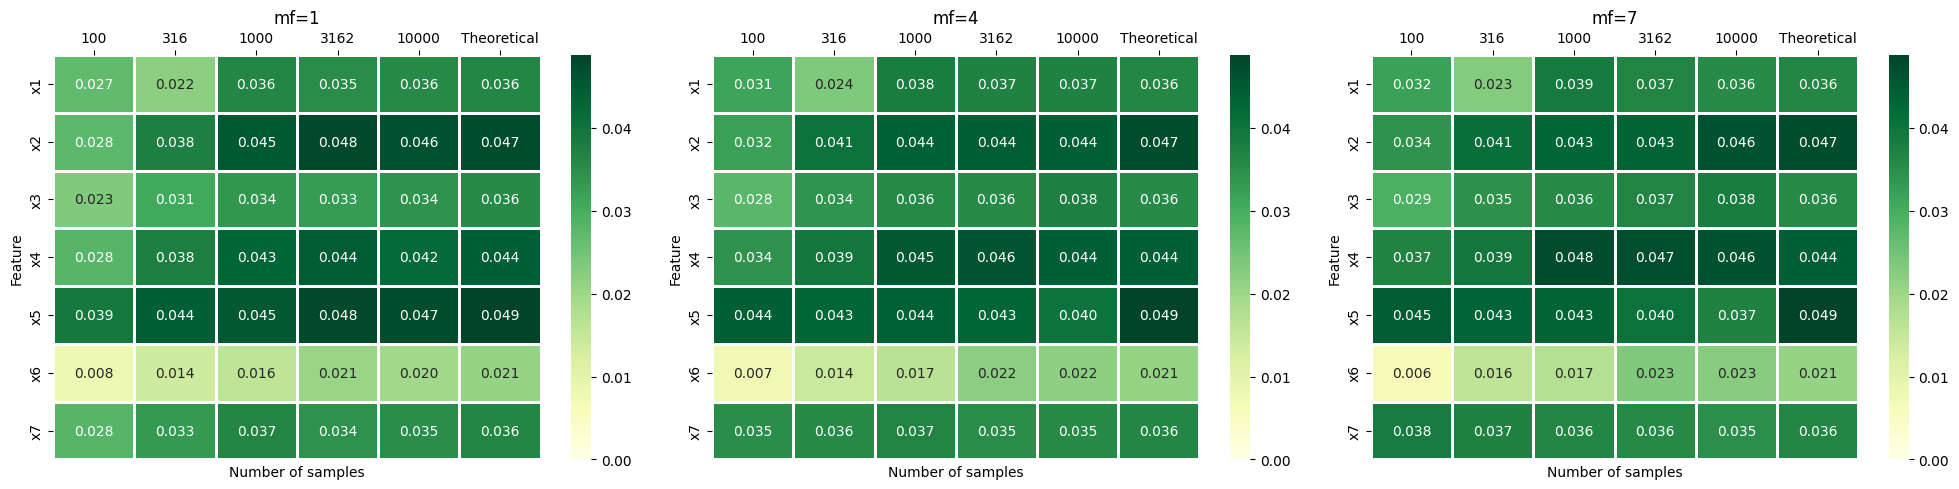

In [101]:
UMDI_mf1 = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_mf4 = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
UMDI_mf7 = pd.DataFrame(
    index=["x1", "x2", "x3", "x4", "x5", "x6", "x7"],
)
for t_idx in range(len(train_sizes)):
    UMDI_mf1.loc[:,f"{train_sizes[t_idx]}"] = np.mean(umdi_mf[:, t_idx, :, 0], axis=1)
    UMDI_mf4.loc[:,f"{train_sizes[t_idx]}"] = np.mean(umdi_mf[:, t_idx, :, 1], axis=1)
    UMDI_mf7.loc[:,f"{train_sizes[t_idx]}"] = np.mean(umdi_mf[:, t_idx, :, 2], axis=1)

UMDI_mf1.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)
UMDI_mf4.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)
UMDI_mf7.loc[:, "Theoretical"] = np.mean(theoretical_value, axis=0)

max_value = np.max([UMDI_mf1.max(), UMDI_mf4.max(), UMDI_mf7.max()])

# Plot the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(
    UMDI_mf1,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[0],
    vmin=0,
    vmax=max_value,
)
axes[0].xaxis.tick_top()
axes[0].set_xlabel("Number of samples")
axes[0].set_ylabel("Feature")
axes[0].set_title("mf=1")

sns.heatmap(
    UMDI_mf4,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[1],
    vmin=0,
    vmax=max_value,
)
axes[1].xaxis.tick_top()
axes[1].set_xlabel("Number of samples")
axes[1].set_ylabel("Feature")
axes[1].set_title("mf=4")

sns.heatmap(
    UMDI_mf7,
    annot=True,
    cmap="YlGn",
    fmt=".3f",
    linewidths=1,
    ax=axes[2],
    vmin=0,
    vmax=max_value,
)
axes[2].xaxis.tick_top()
axes[2].set_xlabel("Number of samples")
axes[2].set_ylabel("Feature")
axes[2].set_title("mf=7")

plt.tight_layout()
plt.show()

In [11]:
X, y = make_noised_led_sample(20000, flip_proba=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

dummy = DummyClassifier(random_state=42)
dummy.fit(X_train, y_train)
theoretical_value_nofolds = np.array(
    [shapley_conditional_variance(X, y, m) for m in range(7)]
)
print("Sum of theoretical value: ", theoretical_value_nofolds.sum())
print(
    "Brier score of the null model: ",
    brier_score_loss(y_test, dummy.predict_proba(X_test)),
)
for mf in [1, 4, 7]:
    rf = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=None,
        max_features=mf,
        min_samples_leaf=1,
        random_state=42,
    )
    rf.fit(X_train, y_train)

    print(
        f"Brier score of the model for mf = {mf}: ",
        brier_score_loss(y_test, rf.predict_proba(X_test)),
    )

Sum of theoretical value:  0.26958053195121967
Brier score of the null model:  0.9001541
Brier score of the model for mf = 1:  0.6466036601919466
Brier score of the model for mf = 4:  0.6466036601919466
Brier score of the model for mf = 7:  0.6466036601919466
